In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras import backend as K, layers
HDF5_DISABLE_VERSION_CHECK=1
import fr_utils
K.set_image_data_format('channels_last')
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL
from keras_facenet import FaceNet
# tf.random.set_seed(1)


# Loading Facenet


In [4]:
# from tensorflow.keras.models import model_from_json
# import json
# with open('keras-facenet-h5/model.json') as user_file:
#   parsed_json = user_file.read()
# user_file.close()
# base_model = model_from_json(parsed_json)
# base_model.load_weights('keras-facenet-h5/facenet_keras_weights.h5')
# Facenet = model_from_json(parsed_json)
# Facenet.load_weights('keras-facenet-h5/model.h5')
from inception_resnet_v1 import *
myFacenet = InceptionResNetV1(input_shape=(160, 160, 3),
                      classes=128,
                      dropout_keep_prob=0.8,
                      weights_path="keras-facenet-h5/facenet_keras_weights.h5")
myFacenet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

# in this section we're going to make dataset to train a siamese network
# 1500 of the classes were chosen and we are gonna make dataset of these


In [3]:
import os
PATH = "image/lfw"
dirs = sorted(os.listdir(PATH))
USE_SUBSET = True
if USE_SUBSET:
    # dirs = dirs[:2500]
    dirs = random.sample(dirs,2500)

name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}
num_classes = len(name_to_classid)

print("number of classes: ", num_classes)

number of classes:  2500


In [4]:
img_paths = {c: [PATH +"/"+ subfolder + "/" + img
                 for img in sorted(os.listdir(PATH +"/"+ subfolder))]
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v: k for k, v in enumerate(all_images_path)}
id_to_path = {v: k for k, v in path_to_id.items()}


In [5]:
classid_to_ids = {k: [path_to_id[path] for path in v] for k, v in img_paths.items()}
id_to_classid = {v: c for c,imgs in classid_to_ids.items() for v in imgs}
dict(list(id_to_classid.items()))

{0: 0,
 1: 1,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 6,
 9: 7,
 10: 7,
 11: 7,
 12: 7,
 13: 7,
 14: 7,
 15: 7,
 16: 8,
 17: 9,
 18: 10,
 19: 11,
 20: 11,
 21: 11,
 22: 12,
 23: 12,
 24: 12,
 25: 12,
 26: 13,
 27: 14,
 28: 15,
 29: 16,
 30: 17,
 31: 18,
 32: 19,
 33: 20,
 34: 20,
 35: 20,
 36: 21,
 37: 21,
 38: 21,
 39: 21,
 40: 21,
 41: 21,
 42: 22,
 43: 23,
 44: 24,
 45: 25,
 46: 26,
 47: 27,
 48: 27,
 49: 27,
 50: 28,
 51: 29,
 52: 30,
 53: 31,
 54: 32,
 55: 32,
 56: 33,
 57: 34,
 58: 35,
 59: 36,
 60: 37,
 61: 38,
 62: 39,
 63: 39,
 64: 40,
 65: 40,
 66: 41,
 67: 42,
 68: 42,
 69: 43,
 70: 44,
 71: 45,
 72: 46,
 73: 46,
 74: 46,
 75: 46,
 76: 46,
 77: 46,
 78: 46,
 79: 47,
 80: 48,
 81: 49,
 82: 49,
 83: 49,
 84: 50,
 85: 50,
 86: 50,
 87: 51,
 88: 52,
 89: 52,
 90: 53,
 91: 54,
 92: 55,
 93: 56,
 94: 57,
 95: 58,
 96: 59,
 97: 60,
 98: 61,
 99: 62,
 100: 63,
 101: 64,
 102: 64,
 103: 65,
 104: 66,
 105: 66,
 106: 66,
 107: 66,
 108: 67,
 109: 67,
 110: 68,
 111: 69,
 112: 70

In [6]:

[(classid_to_name[x], len(classid_to_ids[x]))
 for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1]]

[('George_W_Bush', 530),
 ('Colin_Powell', 236),
 ('Tony_Blair', 144),
 ('Donald_Rumsfeld', 121),
 ('Junichiro_Koizumi', 60),
 ('Jean_Chretien', 55),
 ('Jacques_Chirac', 52),
 ('Gloria_Macapagal_Arroyo', 44),
 ('Arnold_Schwarzenegger', 42),
 ('Jennifer_Capriati', 42),
 ('Laura_Bush', 41),
 ('Alejandro_Toledo', 39),
 ('Nestor_Kirchner', 37),
 ('Andre_Agassi', 36),
 ('Megawati_Sukarnoputri', 33),
 ('Tom_Ridge', 33),
 ('Vicente_Fox', 32),
 ('Recep_Tayyip_Erdogan', 30),
 ('Guillermo_Coria', 30),
 ('Juan_Carlos_Ferrero', 28),
 ('Gray_Davis', 26),
 ('Winona_Ryder', 24),
 ('Atal_Bihari_Vajpayee', 24),
 ('Jose_Maria_Aznar', 23),
 ('Saddam_Hussein', 23),
 ('Hamid_Karzai', 22),
 ('Lindsay_Davenport', 22),
 ('George_Robertson', 22),
 ('Jennifer_Lopez', 21),
 ('Angelina_Jolie', 20),
 ('Igor_Ivanov', 20),
 ('Julianne_Moore', 19),
 ('John_Howard', 19),
 ('Carlos_Moya', 19),
 ('Pervez_Musharraf', 18),
 ('Lance_Armstrong', 18),
 ('Fidel_Castro', 18),
 ('John_Kerry', 17),
 ('Jean_Charest', 17),
 ('Tren

# Implementing function to make Pos and Neg Pairs for Training

In [7]:
# build pairs of positive image ids for a given classid
import itertools
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]

    if len(imgs) == 1:
        return []

    pos_pairs = list(itertools.combinations(imgs, 2))

    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

In [8]:
def build_neg_pairs_for_id(classid, classes, max_num=20):
    imgs = classid_to_ids[classid]
    neg_classes_ids = random.sample(classes, max_num+1)

    if classid in neg_classes_ids:
        neg_classes_ids.remove(classid)

    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_ids[neg_classes_ids[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]

    return neg_pairs

# Loading Images

In [9]:
import cv2
def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        all_imgs += [cv2.resize(img,(160,160))]

    return np.array(all_imgs)
all_imgs = open_all_images(id_to_path)

# Building Dataset
# 80 percent of the all of the pairs are gonna used for training and 20 percent for Test

In [10]:
def build_train_test_data(split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)

    # train
    for class_id in range(split):
        pos = build_pos_pairs_for_id(class_id)
        neg = build_neg_pairs_for_id(class_id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1.0]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0.0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY,dtype=float)[perm]

    listX1 = []
    listX2 = []
    listY = []

    #test
    for id in range(split, num_classes):
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(range(split, num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY , dtype=float)
    return (X1_ids_train, X2_ids_train, Y_ids_train,
            X1_ids_test, X2_ids_test, Y_ids_test)

In [11]:
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data()

In [12]:
no_zeros = train_Y[np.where(train_Y==0)]

# Making Generator to make Batches of 32 Sample of pairs for training

In [13]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]

    def __len__(self):
        return self.num_samples // self.batch_size

    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset.

        Keras choose by itself the order in which batches are created, and several may be created
        in the same time using multiprocessing. Therefore, avoid any side-effect in this method!
        """
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size

        imgs1 = self.imgs[self.X1[low_index:high_index]]
        imgs2 = self.imgs[self.X2[low_index:high_index]]
        targets = np.array(self.Y[low_index:high_index])

        return ([imgs1, imgs2], targets)

In [14]:
gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs)

In [15]:
print("Number of batches: {}".format(len(gen)))

Number of batches: 323


In [16]:
[x1, x2], y = gen[1]

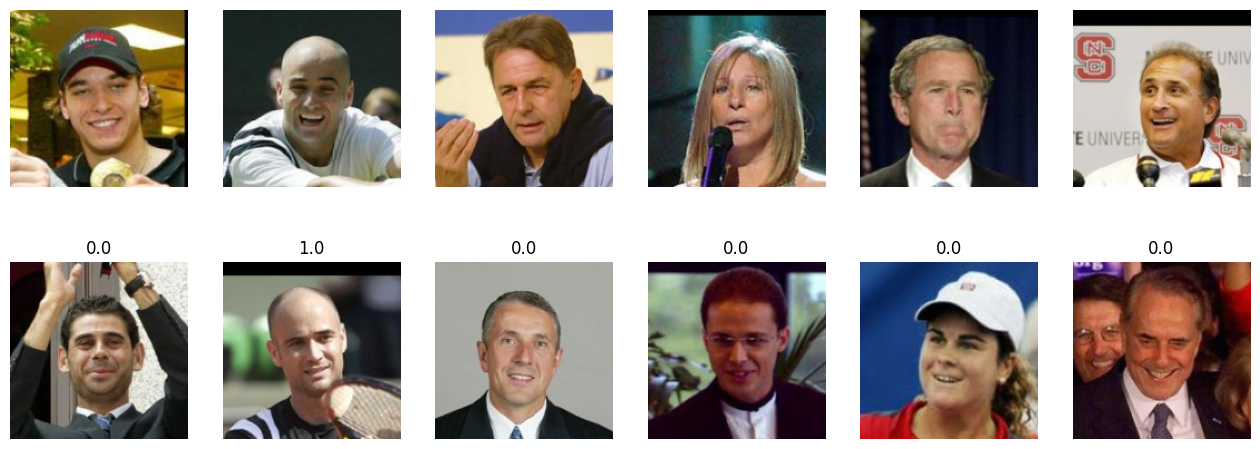

(32,)

In [80]:
plt.figure(figsize=(16, 6))

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x1[i+13] / 255)
    plt.axis('off')

for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(x2[i+13] / 255)
    plt.title(y[i+13])

    plt.axis('off')
plt.show()
y.shape

In [18]:
second_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (160,160,3))
for layer in second_model.layers:
  layer.trainable = False

# Euclidean Distance to compute distance between to embeded vector for Metric Learning

In [5]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))
# def distance(vects):
#     x, y = vects
#     return tf.subtract(x,y)
# def cosine_distance(vests):
#     x, y = vests
#     x = K.l2_normalize(x, axis=-1)
#     y = K.l2_normalize(y, axis=-1)
#     return -K.mean(x * y, axis=-1, keepdims=True)
# def cos_dist_output_shape(shapes):
#     shape1, shape2 = shapes
#     return (shape1[0],1)

# Face Verifier Model : Model would get 2 images as input and after passing images through Facenet , euclidean distance gonna be computed and after that batch normalization and finally a dense layer with a single neuron gonna be used as output layer with sigmoid activation function .
# Here Transfer learning is used and last layers of the facenet gonna be trained

In [6]:
def Face_verifier():
    input1 = keras.Input(shape = (160,160,3),name="input1")
    input2 = keras.Input(shape =(160,160,3),name="input2")
    embeding1 =myFacenet (input1)
    embeding2 =myFacenet (input2)
    merge_layer  = layers.Lambda(euclidean_distance)([embeding1,embeding2])
    normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
    outputs = layers.Dense(1, activation="sigmoid")(normal_layer)
    model = Model(inputs=[input1, input2], outputs=outputs)
    return model


# Loss Function : Using Contrastive Loss because it's a siamese network and  we have small number of instance per each person

In [7]:
def loss():
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, "float32")
        return tf.reduce_mean( y_true * tf.square(1 - y_pred) +
                      (1 - y_true) * tf.square(tf.maximum(y_pred - 0.25, 0)))
    return contrastive_loss

# Computing classification accuracy with a fixed threshold on similarity

In [8]:
def accuracy_sim(y_true, y_pred, threshold=0.5):
    y_thresholded = tf.cast(y_pred > threshold, "float32")
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_thresholded), "float32"))

In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives =K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives =K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
Verifier_model = Face_verifier()
Verifier_model.compile(
    loss=loss(), optimizer="RMSprop", metrics=[accuracy_sim,f1_m,precision_m,recall_m,"accuracy"]
)

# Stop training in layer 0 - 300 of the facenet and let last layers parameter be trainable. It's fine tuning

In [25]:
print("Number of layers in the base model: ", len(myFacenet.layers))
fine_tune_at = 300
myFacenet.trainable =True
# Freeze all the layers before the `fine_tune_at` layer
for layer in myFacenet.layers[:fine_tune_at]:
  layer.trainable = False
Verifier_model.summary()

Number of layers in the base model:  448
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Functional (None, 128)          22808144    input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 1)            

In [26]:
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

In [27]:
History = Verifier_model.fit_generator(generator=gen,
                    epochs=10,
                    shuffle=True,
                    validation_data=([test_X1, test_X2], test_Y),
                    verbose=1
                   )

Epoch 1/10


C:\Users\smrh1\.conda\envs\tensorflow_gpu_CNN\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


323/323 [==============================] - 91s 224ms/step - loss: 0.0914 - accuracy_sim: 0.7773 - f1_m: 0.7882 - precision_m: 0.7382 - recall_m: 0.8606 - accuracy: 0.7773 - val_loss: 0.0906 - val_accuracy_sim: 0.7036 - val_f1_m: 0.6656 - val_precision_m: 0.5925 - val_recall_m: 0.8343 - val_accuracy: 0.7037
Epoch 2/10
323/323 [==============================] - 72s 222ms/step - loss: 0.0542 - accuracy_sim: 0.8532 - f1_m: 0.8637 - precision_m: 0.7888 - recall_m: 0.9660 - accuracy: 0.8532 - val_loss: 0.0750 - val_accuracy_sim: 0.7747 - val_f1_m: 0.6995 - val_precision_m: 0.6394 - val_recall_m: 0.8346 - val_accuracy: 0.7753
Epoch 3/10
323/323 [==============================] - 73s 227ms/step - loss: 0.0365 - accuracy_sim: 0.8986 - f1_m: 0.9021 - precision_m: 0.8419 - recall_m: 0.9808 - accuracy: 0.8986 - val_loss: 0.0744 - val_accuracy_sim: 0.8101 - val_f1_m: 0.7081 - val_precision_m: 0.6765 - val_recall_m: 0.7895 - val_accuracy: 0.8102
Epoch 4/10
323/323 [==============================] - 

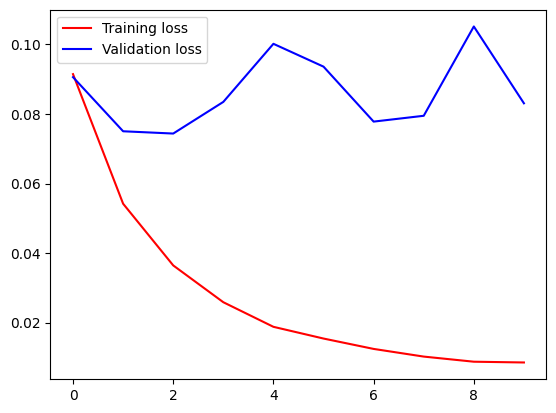

In [33]:
import matplotlib.pyplot as plt
accuracy=History.history['accuracy']
val_accuracy = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs=range(len(accuracy))
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.legend(loc=0)

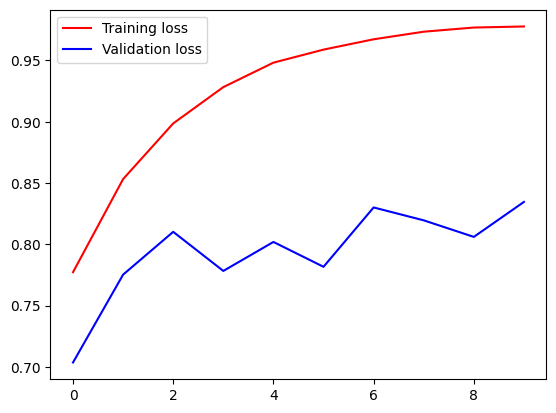

In [34]:
plt.plot(epochs,accuracy,'r',label='Training loss')
plt.plot(epochs,val_accuracy,'b',label='Validation loss')
plt.legend(loc=0)

In [64]:
Verifier_model.save_weights("Final/myFacenet_weights.h5")

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'Final/myFacenet_weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [65]:
Verifier_model.save_weights("Final_model/myFacenet_weights")
Verifier_model.save('Final_model/my_model')
Verifier_model.save('Final_model/myFacenet.h5')

INFO:tensorflow:Assets written to: Final_model/my_model\assets


C:\Users\smrh1\.conda\envs\tensorflow_gpu_CNN\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [9]:
Verifier_model = Face_verifier()
Verifier_model.load_weights('Final_model/my_model')

In [10]:
def load_img(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    x_train = np.expand_dims(img, axis=0)
    return x_train
pred=Verifier_model.predict([load_img("image/messi/6.jpeg") ,load_img("image/messi/5.jpeg")])
if np.squeeze(pred)<0.8:
    print("Not the same person")
    print(pred)
else:
    print("Same Person")

Same Person


In [11]:
def load_img(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    x_train = np.expand_dims(img, axis=0)
    return x_train
pred=Verifier_model.predict([load_img("image/lfw/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg") ,load_img("image/lfw/Beth_Blough/Beth_Blough_0001.jpg")])
if np.squeeze(pred)<0.8:
    print("Not the same person")
    print(pred)
else:
    print("Same Person")


Not the same person
[[0.0011983]]


# Using just facenet for predicting
# if normalize subtract of Vectors is less than 0.8 both picture are of the same person otherwise It's not

In [2]:
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [32]:
database = {}
database["messi"] = load_img("image/messi/5.jpeg", Facenet)
database["naser"] = load_img("image/lfw-deepfunneled/Abdel_Nasser_Assidi/1.jpg", Facenet)
database['abdou'] = load_img("image/lfw-deepfunneled/Abdoulaye_Wade/Abdoulaye_Wade_0002.jpg", Facenet)
database['warner']= load_img("image/lfw-deepfunneled/Mark_Warner/Mark_Warner_0002.jpg", Facenet)
database['mikhail'] = load_img("image/lfw-deepfunneled/Mikhail_Wehbe/Mikhail_Wehbe_0003.jpg", Facenet)
database["jeanne"]=load_img("image/lfw-deepfunneled/Jeanne_Moreau/Jeanne_Moreau_0002.jpg",Facenet)


NameError: name 'Facenet' is not defined

In [ ]:
def verify(image_path, identity, database, model):
    encoding = img_to_encoding(image_path,model)
    dist = np.linalg.norm(encoding-database[identity])
    if dist<0.8:
        print("It's " + str(identity) )
        Same = True
    else:
        print("It's not " + str(identity) )
        Same = False
    return dist, Same

In [ ]:
verify("image/messi/4.jpeg","messi",database,Facenet)